In [2]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D as ContinuousConv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from odft_tools.layers import ContinuousConv1D
import numpy as np

 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'test_data/HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'test_data/HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    layer1 = ContinuousConv1D(filters=64, kernel_size=60, activation='relu', input_shape=(n_timesteps,n_features), mean=0, stddev=0.05)
    model.add(layer1)# 
    model.add(ContinuousConv1D(filters=64, kernel_size=60, activation='relu', mean=0, stddev=0.05)) # mean=1, stddev=6
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model_before = model
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model, model_before
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    weights = []
    for r in range(repeats):
        score, model, model_before = evaluate_model(trainX, trainy, testX, testy)
        print(np.shape(model.layers[0].get_weights()[0]))
        weights.append(model.layers[0].get_weights()[0])
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
    # summarize results
    summarize_results(scores)
    return weights

    
# run the experiment
weights = run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(60, 9, 64)


KeyboardInterrupt: 

In [25]:
mean = tf.convert_to_tensor(np.asarray([[2, 1]]))
print(mean)
stdf = tf.convert_to_tensor(np.asarray([[2, 1]]))
tf.concat([mean, stdf], 0)

tf.Tensor([[2 1]], shape=(1, 2), dtype=int64)


<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[2, 1],
       [2, 1]])>

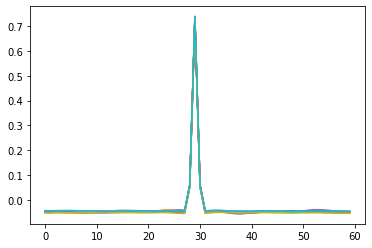

In [2]:
from matplotlib import pyplot as plt

for weight in weights:
    plt.plot(weight[:, 0, 0])
plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from odft_tools.layers import ContinuousConv1D

input_shape = (120, 1)
x = tf.random.normal((1, 120, 2))
print(np.shape(x))
# y = ContinuousConv1D(32, 3, activation='relu', input_shape=input_shape[1:], mean=1, stddev=6)(x)
y = ContinuousConv1D(filters=2, kernel_size=10, activation='relu', input_shape=input_shape, mean=1, stddev=6)(x)
print(y.shape)

(1, 120, 2)
(1, 111, 2)
